# Working with Geographic Data for Summer Housing Project

## 1. Find Census tract from each renting unit to merge with Census Data 

In [ ]:
import os
os.chdir('/Users/alexiawitthaus/Desktop/Portofolio')
os.getcwd()

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString

In [63]:
#ga is the shapefile of Georgia by Census and rent_data is a file containing information about renting unit and price
ga = gpd.read_file('tl_2021_13_tract/tl_2021_13_tract.shp')
rent_data = pd.read_csv("SingleFamilyRentalsAtlantaArea_07072022.csv")

In [64]:
ga.head(1)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,13,221,960204,13221960204,9602.04,Census Tract 9602.04,G5020,S,56805722,528917,+33.9813390,-083.2146320,"POLYGON ((-83.27914 33.95465, -83.27861 33.954..."


In [65]:
rent_data.head(1)

,Street,City,State,Zip,Price,SqFt,Acreage,Beds,Baths,geoadd,Latitude,Longitude
0,103 Meadow Side Ct,Carrollton,GA,30116,2249,1436.0,0.42,3.0,2.0,"103 Meadow Side Ct, Carrollton, GA 30116",33.568164,-85.04062


In [ ]:
#Create function that takes in long and lat and returns GeoId 
def geo_id(long,lat): 
    #Create a point of long and lat 
    p1= Point(long,lat)
    #iterate over all the possible GeoID and test whether point lies in Polygon 
    for i in range(ga.shape[0]):
        poly = ga.iloc[i, 12]
        if p1.within(poly):
            #return GeoID where the point lies inside
            return ga.iloc[i, 3]       

In [ ]:
#Apply function to renting data 
rent_data['GEO_ID'] = rent_data.apply(lambda x:geo_id(x['Longitude'], x['Latitude']), axis=1)

In [ ]:
# Load in previously cleaned Census data
census_data = pd.read_csv("external_data.csv")

In [ ]:
# Merge census data with Renting data to improve accuracy of models
merged_dat = rent_data.merge(census_data, on='GEO_ID', how='left')

## 2. Create visualizations of external data 

In [ ]:
# Use these datasets to create a shapefile of Atlanta by Census tract (not directly available by Census)
georgia_census_tract= gpd.read_file("tl_2021_13_tract/tl_2021_13_tract.shp")
us_county = gpd.read_file("tl_2021_us_county/tl_2021_us_county.shp")
atlanta_counties = gpd.read_file('Counties_Atlanta_Region/Counties_Atlanta_Region.shp')

In [ ]:
#Create function that takes in the  geometry for the census tract and gives out the county that that census tract belongs to
def county(geometry):
    #Define poly1 as the geometry given( in our case Census tract)  
    poly1 = geometry
    #Iterate over all counties in the US
    for i in range(us_county.shape[0]): 
        #poly2 is defined as the county
        poly2 = us_county.iloc[i, 17]
        #If the cenus tract lies within the county, return the name of the county
        if poly1.within(poly2): 
            return us_county.iloc[i,5]

In [ ]:
# Apply function to the shape file for each census tract in Georgia
georgia_census_tract['County'] = georgia_census_tract.apply(lambda x:county(x['geometry']), axis=1)

In [ ]:
# Filter for Counties considered Atlanta( defined by Census)
atlanta_census_tract = georgia_census_tract[georgia_census_tract['County'].isin(atlanta_counties['NAMELSAD10'])]

In [ ]:
#rename GEOID column
atlanta_census_tract_copy = atlanta_census_tract.copy()
atlanta_census_tract_copy.rename(columns={'GEOID': 'GEO_ID'}, inplace=True)

In [ ]:
#convert GeoId to numeric
atlanta_census_tract_copy["GEO_ID"] = pd.to_numeric(atlanta_census_tract_copy["GEO_ID"], errors='coerce')
#merge atlanta shape file to census data 
atlanta_data = atlanta_census_tract_copy.merge(census_data, on='GEO_ID', how='left')

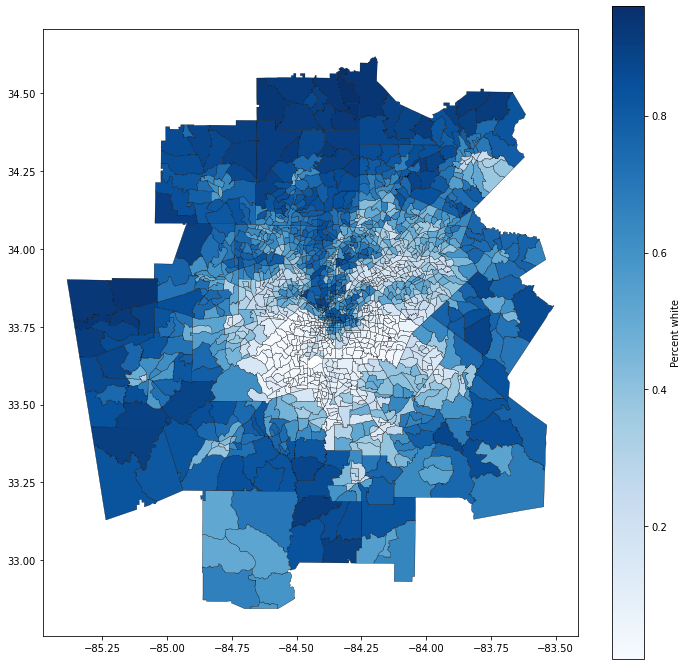

In [60]:
#Example of plot (shown in presentation)
fig, ax = plt.subplots(figsize=(12,12))

atlanta_data.plot(column='Percent white', ax=ax, 
                  edgecolor='black', linewidth=0.3, 
                  cmap='Blues', legend=True,
                  legend_kwds={'label':"Percent white"});